# Лабораторная работа 7
## Задания:

1. Взять последовательность изображений или видео (4-5 кадров) на различную тематику: движение автомобиля, самолета, человека и т.п.
2. Применить к этим кадрам последовательно алгоритм поиска движущихся объектов
3. Отразить траекторию движения объекта на начальном (первом) изображении с использованием функции рисования фигур cv2
4. Перенести траекторию движения объекта на 2D-плоскость с сохранением направления движения и ключевых точек нахождения объекта на каждом из кадров.
5. Вывести результат на экран.

## Подготовка окружения

In [1]:
# 1) Импорт всех необходимых библиотек
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from rich.table import Table
from gz_utils_balcon import EntityManager
import rclpy
from rclpy.wait_for_message import wait_for_message
from cv_bridge import CvBridge
from sensor_msgs.msg import Image
import time
import copy
#Rich
from rich.progress import track

# 2) Инциализация `rclpy` и создания node для наблюдения за сообщениями
if not rclpy.ok():
    rclpy.init()
    node = rclpy.create_node("simple_node")

node.set_parameters([rclpy.parameter.Parameter("use_sim_time", rclpy.Parameter.Type.BOOL, True)])




# 3) Создания CvBridge
bridge = CvBridge()

# 4) Создания экземпляра EntityManager для мира "default"
emg = EntityManager("default")


# 5) Функция для получения изображения
def get_image():
    msg = wait_for_message(Image,node,"/camera/rgb/image_raw",time_to_wait=10)
    if msg[0] == False:
        raise TimeoutError
    else:
        img_rgb = bridge.imgmsg_to_cv2(msg[1])
        return img_rgb

# 6) Функция для визуализаций ряда изображений
def vusial_imgs(ls_img):
    plt.figure(figsize=(12,10))
    for i in range(len(ls_img)):
        plt.subplot(4,3,i+1)
        plt.imshow(ls_img[i])


## Ход работы
### 1. Взять последовательность изображений или видео (4-5 кадров) на различную тематику: движение автомобиля, самолета, человека и т.п.


#### Сначала получим фон без объектов

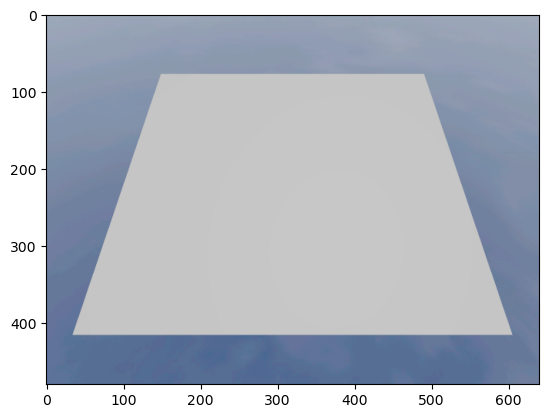

In [2]:
empty_img = get_image()
plt.imshow(empty_img)

#### Найдем точки движения объекта по гиперболе

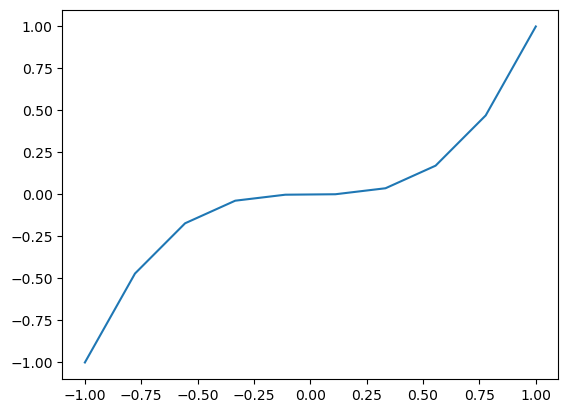

In [4]:
# create 1000 equally spaced points between -10 and 10
x_arr = np.linspace(-1, 1, 10)

# calculate the y value for each element of the x vector
y_arr = x_arr**3

fig, ax = plt.subplots()
ax.plot(x_arr, y_arr)

#### Теперь возьмем несколько изображений

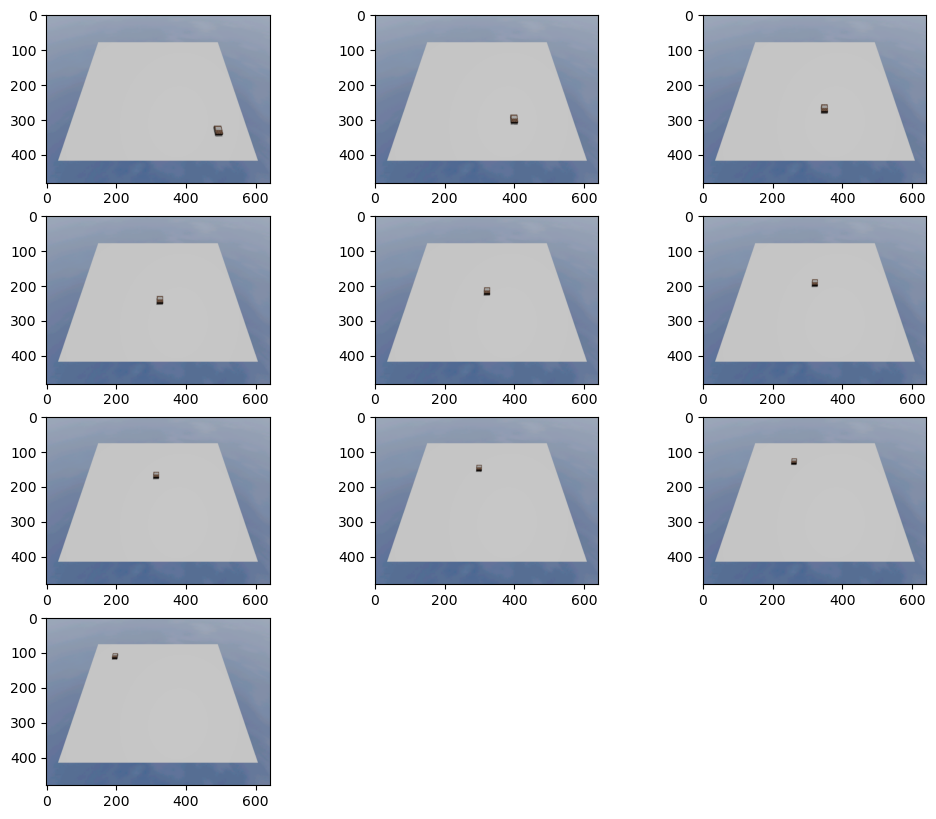

In [5]:
ls_img = []
emg.delete_entity(["unknow"])
for x,y in zip(x_arr,y_arr):
    emg.create_entity("cereal.sdf", x = x,y =y) # оси в симуляцие перепутаны
    img1 = get_image()
    emg.delete_entity(["unknow"])
    # plt.imshow(img1)
    # plt.show()
    ls_img.append(img1)
    time.sleep(0.1)
vusial_imgs(ls_img)

## 2. Применить к этим кадрам последовательно алгоритм поиска движущихся объектов

Output()

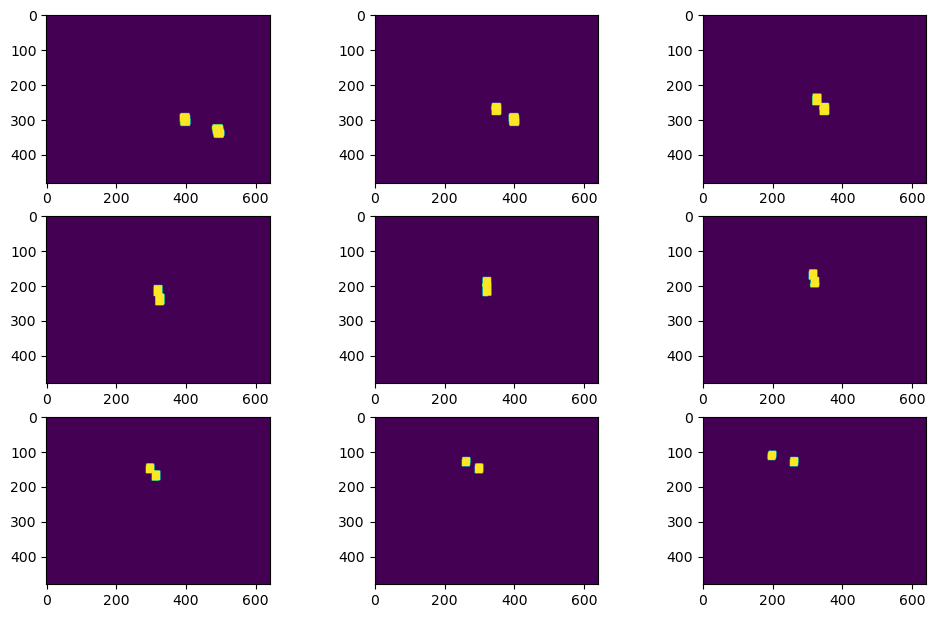

In [129]:
ls_dialated = []
for i in track(range(len(ls_img))):
    if i == len(ls_img)-1:
        continue
    diff = cv.absdiff(ls_img[i], ls_img[i+1])
    gray = cv.cvtColor(diff, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (5,5), 0)

    _, thresh = cv.threshold(blur, 20, 255, cv.THRESH_BINARY)

    dilated = cv.dilate(thresh, None, iterations=3)
    ls_dialated.append(dilated)
vusial_imgs(ls_dialated)
    

### 3. Отразить траекторию движения объекта на начальном (первом) изображении с использованием функции рисования фигур cv2

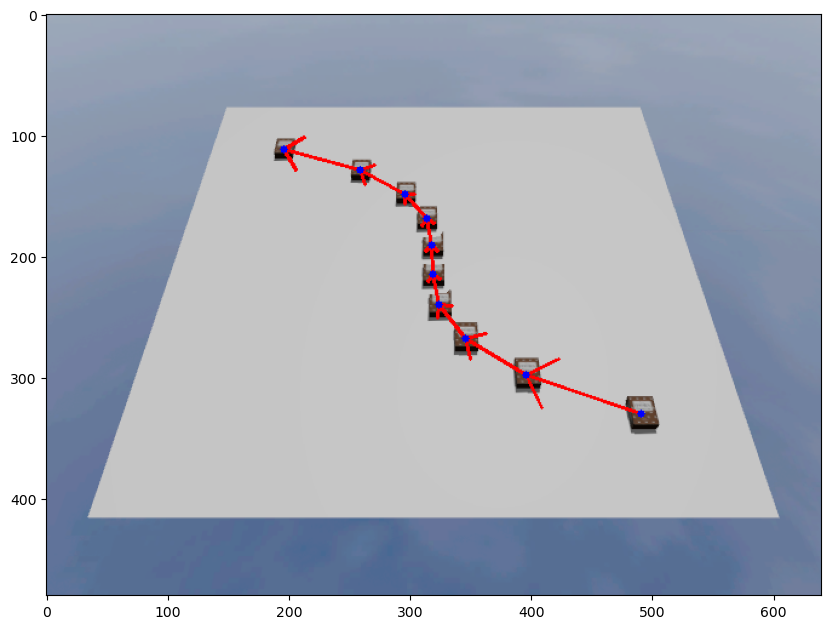

In [146]:

def get_img_with_path(empty_img, ls_img):
    points = []
    empty_img_copy = empty_img.copy()
    masks = []
    for i in range(len(ls_img)):
        frame1 = ls_img[i].copy()
        frame2 = empty_img_copy
        diff = cv.absdiff(frame1, frame2) # нахождение разницы двух кадров, которая проявляется лишь при изменении одного из них, т.е. с этого момента наша программа реагирует на любое движение.
        
        gray = cv.cvtColor(diff, cv.COLOR_BGR2GRAY) # перевод кадров в черно-белую градацию
        
        blur = cv.GaussianBlur(gray, (5, 5), 0) # фильтрация лишних контуров
        
        _, thresh = cv.threshold(blur, 20, 255, cv.THRESH_BINARY) # метод для выделения кромки объекта белым цветом
        
        dilated = cv.dilate(thresh, None, iterations = 3) # данный метод противоположен методу erosion(), т.е. эрозии объекта, и расширяет выделенную на предыдущем этапе область
        
        сontours, _ = cv.findContours(dilated, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) # нахождение массива контурных точек 
    
        M = cv.moments(сontours[0])
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        
        points.append((cx,cy))
        masks.append(dilated)

    for mask, img in zip(masks, ls_img):
        empty_img_copy[mask>0] = img[mask>0] 
    
    for i in range(len(points)):
        if i == len(points)-1:
            continue
        cv.arrowedLine(empty_img_copy,points[i],points[i+1],(255,0,0),2,tipLength=0.3)
    
    for cx,cy in points:
        cv.circle(empty_img_copy,(cx,cy), 3, (0,0,255), -1)
    
    
    return empty_img_copy

plt.figure(figsize=(10,10))
plt.imshow(get_img_with_path(empty_img, ls_img))

### 4. Перенести траекторию движения объекта на 2D-плоскость с сохранением направления движения и ключевых точек нахождения объекта на каждом из кадров.

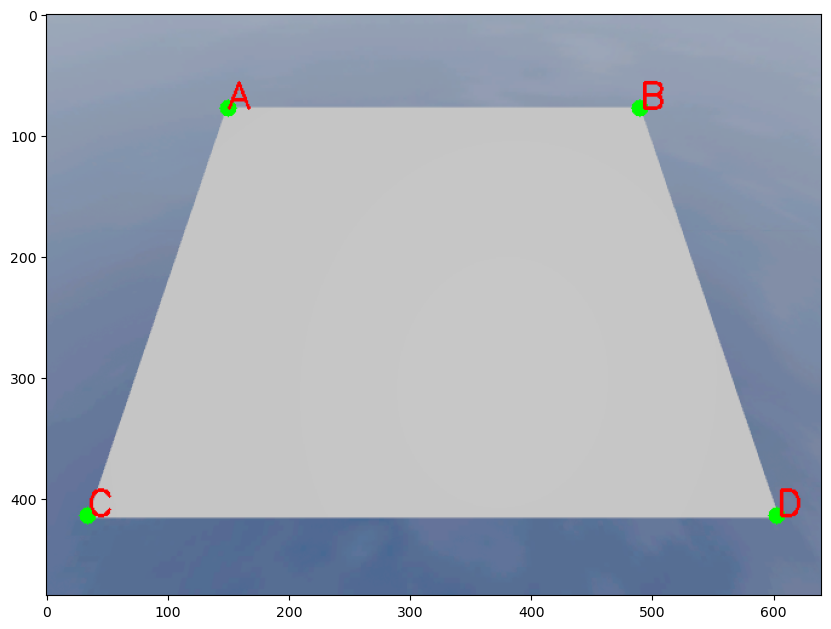

In [117]:
empty_img_copy = empty_img.copy()

# Точки углов 
A = (150, 78) 
B = (490,78)
C = (34,414)
D = (603,414)

plt.figure(figsize=(10,10))

cv.circle(empty_img_copy, A, 7, (0,255,0), -1, 8)
cv.circle(empty_img_copy, B, 7, (0,255,0), -1, 8)
cv.circle(empty_img_copy, C, 7, (0,255,0), -1, 8)
cv.circle(empty_img_copy, D, 7, (0,255,0), -1, 8)
cv.putText(empty_img_copy, 'A', A, cv.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
cv.putText(empty_img_copy, 'B', B, cv.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
cv.putText(empty_img_copy, 'D', D, cv.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
cv.putText(empty_img_copy, 'C', C, cv.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
plt.imshow(empty_img_copy)
plt.show()

In [141]:
def wrap_img(img):
    h_AB = np.sqrt(((A[0] - B[0])**2) + ((A[1] - B[1])**2))
    h_CD = np.sqrt(((C[0] - D[0])**2) + ((C[1] - D[1])**2))
    max_h = max(int(h_AB), int(h_CD))
    
    w_AC = np.sqrt(((A[0] - C[0])**2) + ((A[1] - C[1])**2))
    w_BD = np.sqrt(((B[0] - D[0])**2) + ((B[1] - D[1])**2))
    max_w = max(int(w_AC), int(w_BD))
    
    output_pts = np.float32([[0,0],
                             [0, max_w - 1],
                             [max_h - 1, max_w - 1],
                             [max_h - 1, 0]])
    # empty_img_clip = empty_img.copy()
    img_copy = img.copy()
    M = cv.getPerspectiveTransform(input_pts, output_pts)
    img_clip = cv.warpPerspective(img_copy, M, (max_h, max_w), flags=cv.INTER_LINEAR)
    return img_clip


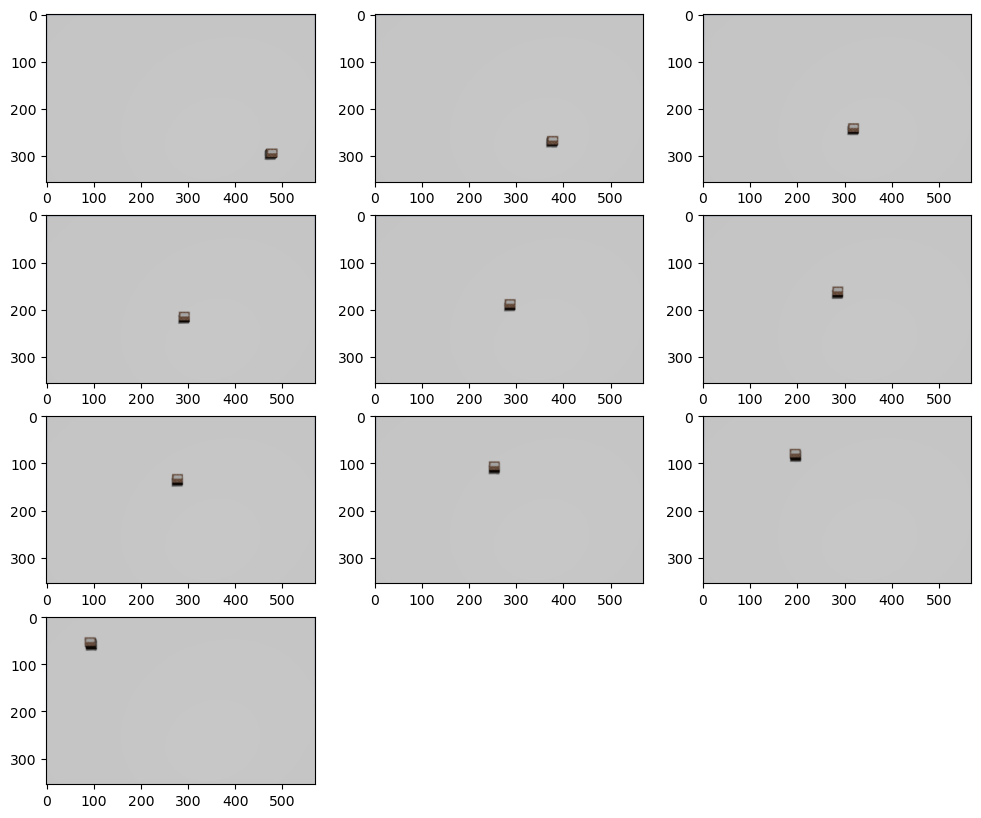

In [132]:
empty_img_clip = wrap_img(empty_img)
ls_img_clip = list( map(wrap_img,ls_img) )
vusial_imgs(ls_img_clip)

### 5. Вывести результат на экран

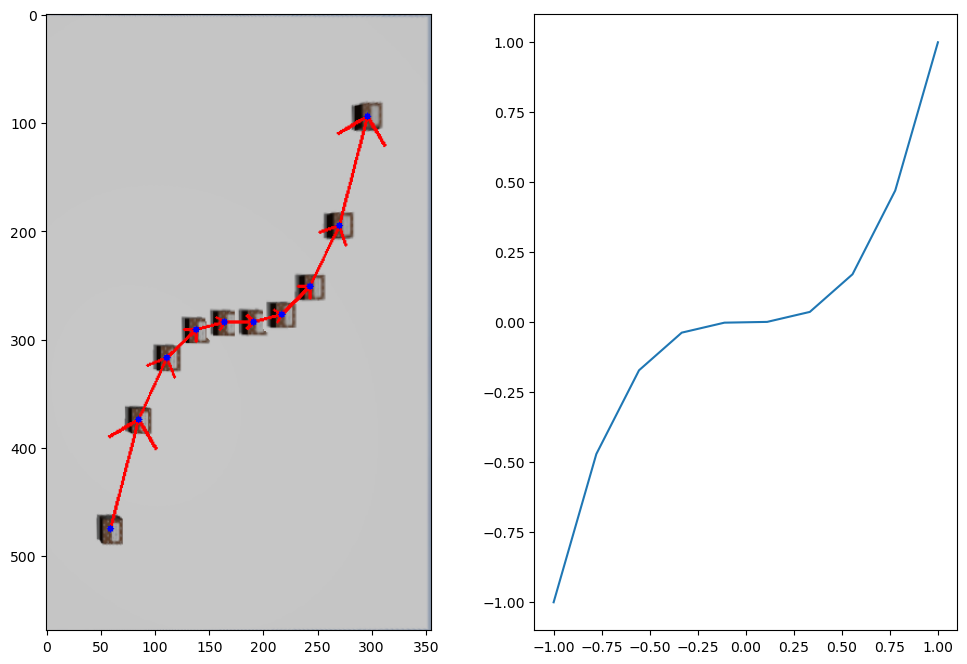

In [153]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
img_temp = get_img_with_path(empty_img_clip, ls_img_clip)
img_temp  = cv.rotate(img_temp , cv.ROTATE_90_CLOCKWISE)
plt.imshow(img_temp)

plt.subplot(1,2,2)
plt.plot(x_arr, y_arr)